In [29]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)
np.bincount(y)

array([50, 50], dtype=int64)

In [2]:
X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     test_size=0.5,
                     random_state=1,
                     stratify=y)

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
import numpy as np

In [4]:
clf1 = LogisticRegression(penalty='l2',
                          C=0.001)
clf2 = DecisionTreeClassifier(max_depth=1,
                               criterion='entropy')
clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')
pipe1 = Pipeline([('sc', StandardScaler()),
                  ('clf', clf1)])
pipe3 = Pipeline([('sc', StandardScaler()),
                  ('clf', clf3)])
clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

In [5]:
print('10-fold cross validation:')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')

10-fold cross validation:
ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


In [6]:
from majorityvote import MajorityVoteClassifier
mv_clf = MajorityVoteClassifier(
    classifiers=[pipe1, clf2, pipe3]
)
clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
evals = []
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    evals.append(scores)
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')


ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


In [7]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
linestyles = [':', '--', '-.', '-']

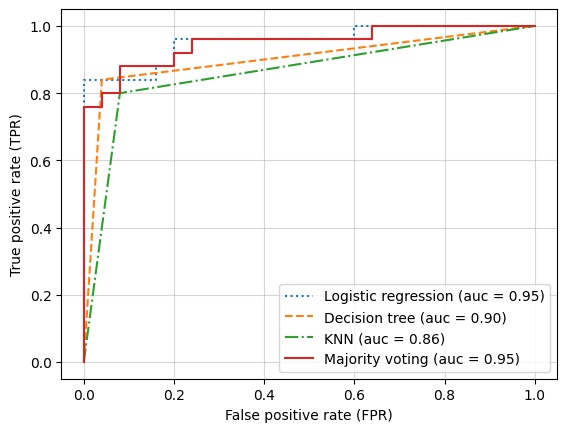

In [8]:
for clf, label, ls in zip(all_clf, clf_labels, linestyles):
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]  # probabilty of the positive class, 1
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,
             linestyle=ls,
             label=f'{label} (auc = {roc_auc:.2f})')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.show()

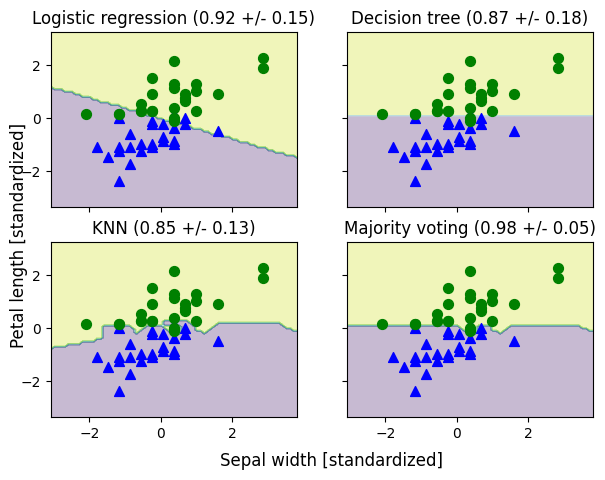

In [9]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
from itertools import product
x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(nrows=2, ncols=2,
                        sharex='col',
                        sharey='row',
                        figsize=(7, 5))
for idx, clf, tt, i in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels, range(4)):
    clf.fit(X_train_std, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0],
                                  X_train_std[y_train==0, 1],
                                  c='blue',
                                  marker='^',
                                  s=50)
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0],
                                  X_train_std[y_train==1, 1],
                                  c='green',
                                  marker='o',
                                  s=50)
    axarr[idx[0], idx[1]].set_title(tt + f' ({evals[i].mean():.2f} +/- {evals[i].std():.2f})')
plt.text(-3.5, -5.,
         s='Sepal width [standardized]',
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 3.5,
         s='Petal length [standardized]', va='center',
         fontsize=12, rotation=90)
plt.show()

In [10]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()), ('clf', LogisticRegression(C=0.001))]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ('clf', KNeighborsClassifier(n_neighbors=1))]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ('clf', LogisticRegression(C=0.001))],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__multi_class': 'auto',
 'pipeline-1__clf__n_jobs': None,
 'pipeline-1__clf__penalty

In [11]:
from sklearn.model_selection import GridSearchCV
params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator=mv_clf,
                           param_grid=params,
                           cv=10,
                           scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ('clf',
                                                                            LogisticRegression(C=0.001))]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ('clf',
                                                                            KNeighborsClassifier(n_neighbors=1))])]),
             param_grid={'decisiontreeclassifier__max_depth': [1, 2],
                         'pipeline-1__clf__C': [0.001, 0.01, 0.1, 1, 10, 100,
                                                1000]},
             scoring='roc_auc')

In [12]:
grid_search.best_params_

{'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}

In [13]:
cross_val_score(grid_search, X_test, y_test, cv=10, scoring='roc_auc', n_jobs=8).mean()

0.9666666666666668

In [14]:
grid_search.cv_results_['mean_test_score']

array([0.98333333, 0.98333333, 0.98333333, 0.96666667, 0.96666667,
       0.96666667, 0.96666667, 0.98333333, 0.98333333, 0.98333333,
       0.96666667, 0.96666667, 0.96666667, 0.96666667])

In [15]:
for i in range(len(grid_search.cv_results_['mean_test_score'])):
    mean_score = grid_search.cv_results_['mean_test_score'][i]
    std_dv = grid_search.cv_results_['std_test_score'][i]
    params = grid_search.cv_results_['params'][i]
    print(f'{mean_score:.3f} +/- {std_dv:.2f} {params}')

0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.01}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 10}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 1000}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.01}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 10}
0.9

In [16]:
import pandas as pd
wine = pd.read_csv('wine.data', header=None)
wine.columns = ['Class label', 'Alcohol', 'Malic acid',
                    'Ash', 'Alcalinity of ash', 'Magnesium',
                    'Total phenols', 'Flavanoids', 
                    'Nonflavanoid phenols', 'Proanthocyanins',
                    'Color intensity', 'Hue', 
                    'OD280/OD315 of diluted wines', 'Proline']

In [17]:
wine = wine[wine['Class label'] != 1]
wine['Class label'].unique()

array([2, 3], dtype=int64)

In [18]:
X = wine[['Alcohol', 'OD280/OD315 of diluted wines']].values
y = wine['Class label'].values

In [19]:
wine_le = LabelEncoder()
y = wine_le.fit_transform(y)
np.bincount(y)

array([71, 48], dtype=int64)

In [20]:
X_train, X_test, y_train, y_test =\
    train_test_split(X, y,
                     test_size=0.2,
                     stratify=y)
np.bincount(y_train)

array([57, 38], dtype=int64)

In [21]:
from sklearn.ensemble import BaggingClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=None)
bag = BaggingClassifier(estimator=tree,
                        n_estimators=500,
                        max_samples=1.0,
                        max_features=1.0,
                        bootstrap=True,
                        bootstrap_features=False)

In [22]:
from sklearn.metrics import accuracy_score
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree training/testing accuracy: {tree_train:.3f}/{tree_test:.3f}')

Decision tree training/testing accuracy: 1.000/0.917


In [23]:
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)
print(f'Bagging classifier training/testing accuracy: {bag_train:.3f}/{bag_test:.3f}')

Bagging classifier training/testing accuracy: 1.000/0.917


In [31]:
from sklearn.ensemble import AdaBoostClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                              max_depth=1)
ada = AdaBoostClassifier(estimator=tree,
                         n_estimators=500,
                         learning_rate=0.1)
ada.fit(X_train, y_train)
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print(f'XGBoost train/test accuracies: {ada_train:.3f}/{ada_test:.3f}')

XGBoost train/test accuracies: 0.947/0.917


In [27]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(n_estimators=1000, learning_rate=.01, max_depth=4)
xgb_model.fit(X_train, y_train)
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)
xgb_train = accuracy_score(y_train, y_train_pred)
xgb_test = accuracy_score(y_test, y_test_pred)
print(f'XGBoost train/test accuracies: {xgb_train:.3f}/{xgb_test:.3f}')

XGBoost train/test accuracies: 0.947/0.917
